Project Part III

Diversity in recommendations ensures that users are exposed to a wide range of content. Moreover, diversity in sequential group recommendation systems is particularly important since it helps prevent the reinforcement of biases that may arise from repeated exposure to similar types of content. For example, in a system where recommendations are based solely on past behaviour, there is a risk that users will only be exposed to content that aligns with their previous interactions, thus limiting their exposure to new movies. 

In Part III of the project, we would like to promote diversity in recommender systems to offer a wide range of content and ensure that this content is relevant and engaging for
all members of the group. Motivated by the diversification methods we discussed in class, design (7 points) and implement (7 points) a new method for producing diverse sequential group recommendations. Explain why this method works well for the case of sequential group recommendations (6 points). Prepare also a short presentation (about 5 slides) to show how your method works (5 points).

In [32]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from datetime import datetime


In [33]:
links = pd.read_csv('ml-latest-small/links.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

print("Links Dataset:")
display(links.head())

print("\nMovies Dataset:")
display(movies.head())

print("\nRatings Dataset:")
display(ratings.head())

print("\nTags Dataset:")
display(tags.head())

rating_count = ratings.shape[0]
print(f"\nTotal number of ratings: {rating_count}")

Links Dataset:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0



Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Tags Dataset:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200



Total number of ratings: 100836


Selected group users based on the most ratings: [599, 474, 448, 271, 610]

Iteration 1:
User 599 recommendations: ["Schindler's List (1993)", 'Finding Nemo (2003)', "One Flew Over the Cuckoo's Nest (1975)", 'Harry Potter and the Prisoner of Azkaban (2004)', 'Shrek 2 (2004)']
User 474 recommendations: ['Dark Knight, The (2008)', 'Inception (2010)', 'Up (2009)', 'WALL·E (2008)', 'Inglourious Basterds (2009)']
User 448 recommendations: ['Shawshank Redemption, The (1994)', 'Shrek (2001)', 'Saving Private Ryan (1998)', "Schindler's List (1993)", 'Eternal Sunshine of the Spotless Mind (2004)']
User 271 recommendations: ['Matrix, The (1999)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)', 'Forrest Gump (1994)', 'Fight Club (1999)']
User 610 recommendations: ['Good Will Hunting (1997)', 'American History X (1998)', 'Beautiful Mind, A (2001)', "One Flew Over the Cuckoo's Nest (1975)", 'Lion King, The (1994)']
Group recommendations: ["Schindler's List (1993)", 'Shawshank Redemption, 

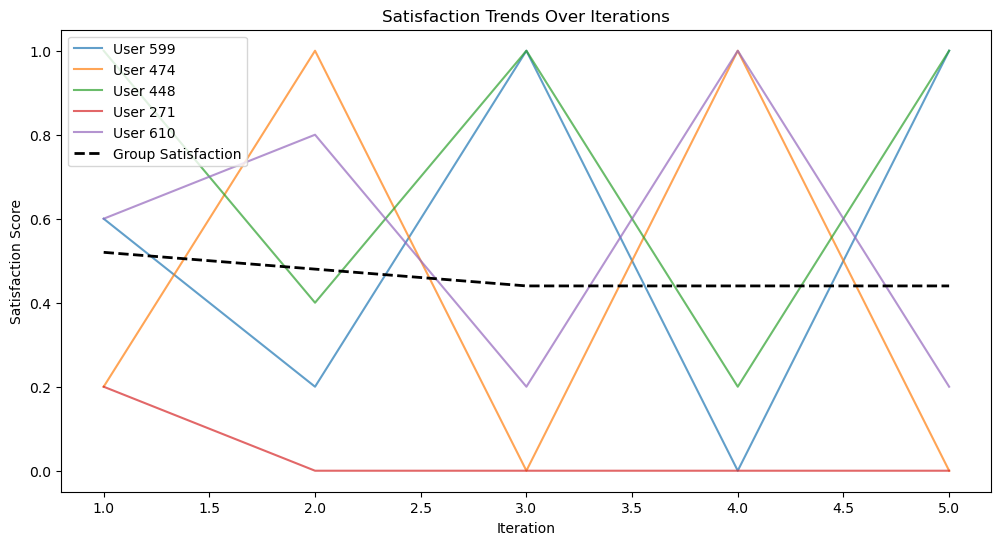

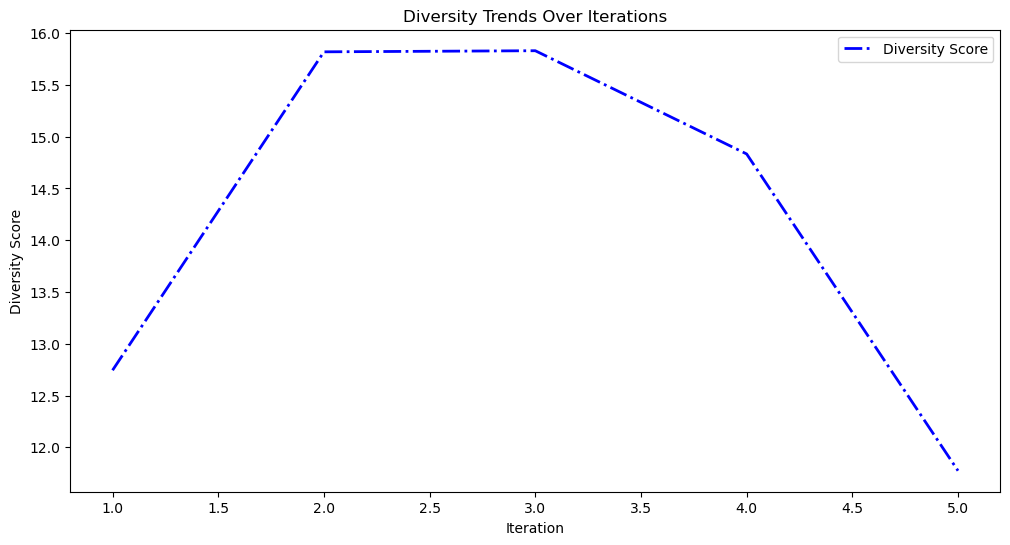

In [ ]:
# User-item matrix for cosine similarity
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
similarity_matrix = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

# Normalize timestamps to scale between 0 and 1
ratings['normalized_time'] = (ratings['timestamp'] - ratings['timestamp'].min()) / \
                             (ratings['timestamp'].max() - ratings['timestamp'].min())

# Compute the number of ratings per user
user_ratings_count = ratings.groupby('userId').size()

# Select the top 5 users with the most ratings
top_users = user_ratings_count.nlargest(6).index.tolist()
group_users = [599, 474, 448, 271, 610]

print(f"Selected group users based on the most ratings: {group_users}")

# Satisfaction scores for the users (initially all unsatisfied)
satisfaction_scores = {user: 0.0 for user in group_users}

# Keep track of movies already recommended for each user and group
user_history = {user: set() for user in group_users}
group_history = set()

# Keep track of satisfaction trends
satisfaction_trends = {user: [] for user in group_users}

# Assume `movies` dataset includes features for movies
movie_features = {row['movieId']: np.random.rand(10) for _, row in movies.iterrows()}  # Replace with real features

# Function to get movie genres
def get_movie_genres(movie_id):
    genres = movies[movies['movieId'] == movie_id]['genres']
    return genres.values[0] if not genres.empty else "Unknown"

# Function to get movie names
def get_movie_title(movie_id):
    title = movies[movies['movieId'] == movie_id]['title']
    return title.values[0] if not title.empty else "Unknown"

# Function to recommend for a user based on similarity
def recommend_for_user(user_id, user_item_matrix, similarity_df, num_recommendations=5):
    similar_users = similarity_df[user_id].sort_values(ascending=False)
    user_rated_movies = user_item_matrix.loc[user_id]
    watched_movies = set(user_rated_movies[user_rated_movies > 0].index)
    scores = pd.Series(dtype=np.float64)
    
    for similar_user, similarity_score in similar_users.items():
        if similar_user == user_id:
            continue
        user_ratings = ratings[ratings['userId'] == similar_user]
        for _, row in user_ratings.iterrows():
            time_weight = row['normalized_time']  # Decay factor for timestamp relevance
            movie_id = row['movieId']
            rating = row['rating']
            # Score calculation includes similarity, rating, and time relevance
            scores[movie_id] = scores.get(movie_id, 0) + rating * similarity_score * time_weight

    # Exclude already watched movies from recommendations
    scores = scores[~scores.index.isin(watched_movies | group_history)]

    # Genre-matching adjustment
    user_ratings = ratings[ratings['userId'] == user_id]
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId']
    high_rated_genres = movies[movies['movieId'].isin(high_rated_movies)]['genres']
    user_genres = set([genre for genres in high_rated_genres for genre in genres.split('|')])
    
    for movie_id in scores.index:
        movie_genres = set(movies[movies['movieId'] == movie_id]['genres'].values[0].split('|'))
        genre_match = len(user_genres & movie_genres)
        scores[movie_id] += genre_match * 0.1  # Adjust scores based on genre overlap

    # Return top recommendations
    recommended_movies = scores.sort_values(ascending=False).head(num_recommendations)
    user_history[user_id].update(recommended_movies.index)
    return [(movie_id, score) for movie_id, score in recommended_movies.items()]
    


# Function to adjust weights dynamically based on dissatisfaction
def fairness_adjusted_weights(satisfaction_scores, alpha=0.7, beta=1.5):
    max_score = max(satisfaction_scores.values())
    weights = {user: alpha + beta * (max_score - satisfaction_scores[user]) for user in satisfaction_scores}
    total_weight = sum(weights.values())
    return {user: weight / total_weight for user, weight in weights.items()}

# Function to calculate diversity score based on genres
def calculate_genre_diversity(movie_ids):
    movie_genres = [set(get_movie_genres(movie_id).split('|')) for movie_id in movie_ids]
    all_genres = set.union(*movie_genres) if movie_genres else set()

    semantic_coverage = len(all_genres)
    dissimilarity_scores = []

    for genres1, genres2 in combinations(movie_genres, 2):
        intersection = len(genres1 & genres2)
        union = len(genres1 | genres2)
        dissimilarity = 1 - (intersection / union) if union > 0 else 0
        dissimilarity_scores.append(dissimilarity)

    avg_dissimilarity = np.mean(dissimilarity_scores) if dissimilarity_scores else 0
    diversity_score = semantic_coverage + avg_dissimilarity 
    return diversity_score

# Simulation over iterations
group_satisfaction_trend = []
diversity_trend = []
num_iterations = 5

for iteration in range(1, num_iterations + 1):
    print(f"\nIteration {iteration}:")
    user_recommendations = {}
    for user in group_users:
        user_recommendations[user] = recommend_for_user(user, user_item_matrix, similarity_df)
        movie_titles = [get_movie_title(movie_id) for movie_id, _ in user_recommendations[user]]
        print(f"User {user} recommendations: {movie_titles}")
    
    # Adjust weights dynamically
    weights = fairness_adjusted_weights(satisfaction_scores)
    
    # Aggregate recommendations for the group
    scores = defaultdict(float)
    for user, recommendations in user_recommendations.items():
        weight = weights[user]
        for movie_id, score in recommendations:
            scores[movie_id] += score * weight
    
    sorted_recommendations = sorted(scores.items(), key=lambda x: -x[1])
    group_recommendations = [movie for movie, _ in sorted_recommendations[:10]]
    group_history.update(group_recommendations)

    # Calculate diversity score
    diversity_score = calculate_genre_diversity(group_recommendations)

    # Print group recommendations and satisfaction
    group_movie_titles = [get_movie_title(movie_id) for movie_id in group_recommendations]
    print(f"Group recommendations: {group_movie_titles}")
    print(f"Genre Diversity Score: {diversity_score:.2f}")
    
    iteration_satisfaction = []
    for user in group_users:
        matched_recommendations = set([movie_id for movie_id, _ in user_recommendations[user]]) & set(group_recommendations)
        total_recommendations = len(user_recommendations[user])
        satisfaction_scores[user] = len(matched_recommendations) / total_recommendations if total_recommendations > 0 else 0
        satisfaction_trends[user].append(satisfaction_scores[user])
        iteration_satisfaction.append(satisfaction_scores[user])

    # Print satisfaction scores for each group member
    print(f"Satisfaction scores: {satisfaction_scores}")

    # Track group-level metrics
    group_satisfaction = np.mean(iteration_satisfaction)
    group_satisfaction_trend.append(group_satisfaction)
    diversity_trend.append(diversity_score)

# Plot satisfaction trends
plt.figure(figsize=(12, 6))
for user, scores in satisfaction_trends.items():
    plt.plot(range(1, num_iterations + 1), scores, label=f'User {user}', alpha=0.7)
plt.plot(range(1, num_iterations + 1), group_satisfaction_trend, label='Group Satisfaction', color='black', linewidth=2, linestyle='--')
plt.title("Satisfaction Trends Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Satisfaction Score")
plt.legend()
plt.show()

# Plot diversity trends
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_iterations + 1), diversity_trend, label='Diversity Score', color='blue', linewidth=2, linestyle='-.')
plt.title("Diversity Trends Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Diversity Score")
plt.legend()
plt.show()